In [242]:
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, make_scorer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler

from imblearn.pipeline import Pipeline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks

from sklearn.inspection import PartialDependenceDisplay, permutation_importance

In [2]:
protien = pd.read_csv("../sequences_training.txt", header=None)
protien.columns = ["protien_seq", "class"]
protien.head()

,protien_seq,class
0,MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...,nonDRNA
1,MEQKKMKYLENLVGKTPMLELIFDYKGEERRIFVKNESYNLTGSIK...,nonDRNA
2,MTILFQLALAALVILSFVMVIGVPVAYASPQDWDRSKQLIFLGSGL...,nonDRNA
3,MSKIERISAFLNDKEVDMTFITNPTTLNYLTGLAIDPHERIAGLMI...,nonDRNA
4,MSDQQQPPVYKIALGIEYDGSKYYGWQRQNEVRSVQEKLEKALSQV...,RNA


In [3]:
import sys

sys.path.append('../')

from FeatureExtraction import extract_features, clean_data

In [4]:
clean_protiens = clean_data(protien)
bio_features = extract_features(clean_protiens)
bio_features.head()

,class,protien_len,mol_weighht,isoelectric_point,Helix,Turn,Sheet,type1,type2,type3,...,N,P,Q,R,S,T,V,W,Y,pos_neg_rat
0,nonDRNA,155,17596.7878,-0.630968,0.341935,0.238710,0.329032,73,37,19,...,4.516129,3.225806,5.161290,6.451613,2.580645,6.451613,5.806452,3.870968,3.225806,1.368420
1,nonDRNA,336,37260.7955,-0.201190,0.366071,0.303571,0.366071,168,75,43,...,5.952381,3.273810,1.190476,2.976190,6.845238,4.166667,6.547619,0.297619,3.571429,1.162790
2,nonDRNA,62,6764.1710,1.579032,0.322581,0.209677,0.580645,48,10,2,...,1.612903,3.225806,4.838710,1.612903,6.451613,1.612903,17.741935,3.225806,1.612903,0.999995
3,nonDRNA,362,39968.9808,-0.141713,0.334254,0.281768,0.356354,187,74,57,...,4.419890,4.143646,2.209945,3.314917,4.696133,5.524862,6.906077,0.276243,2.486188,0.771930
4,RNA,270,30399.2510,-0.314074,0.300000,0.248148,0.355556,138,62,28,...,4.074074,5.555556,4.444444,7.407407,3.703704,5.185185,9.629630,1.851852,4.444444,1.499999


In [5]:
knn = KNeighborsClassifier(n_neighbors=3, p=1, metric="cosine")
X = bio_features.drop(columns=['class'])
y = bio_features['class']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
knn.fit(X_train, y_train)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,1
,metric,'cosine'
,metric_params,None
,n_jobs,None


In [8]:
y_pred = knn.predict(X_test)

In [70]:
precision_score(y_test, y_pred, labels=["nonDRNA"], average=None)

array([0.92615012])

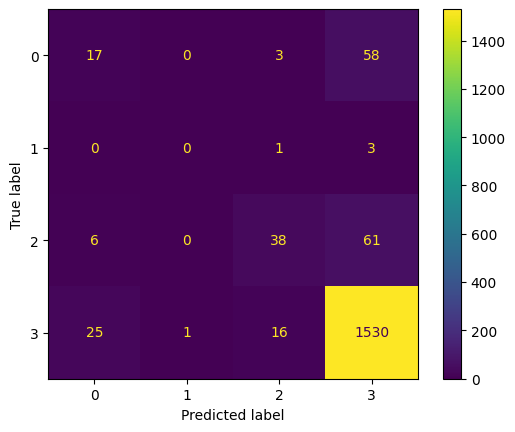

In [9]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [10]:
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)

In [11]:
t_sne = TSNE()

In [12]:
transformed_X = t_sne.fit_transform(X)

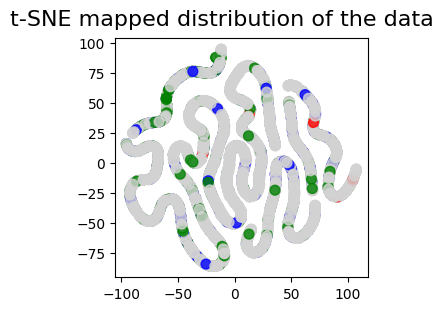

In [13]:
def temp(x):
    if x == "DRNA":
        return "red"
    if x == "DNA":
        return "blue"
    if x == "RNA":
        return "green"
    else:
        return "lightgrey"

y_colored = y.apply(temp)

plot_2d(transformed_X, y_colored, "t-SNE mapped distribution of the data")

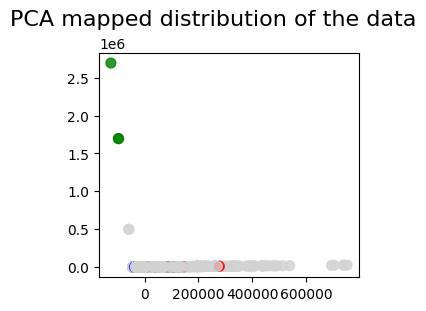

In [14]:
pca = PCA(n_components=2)
plot_2d(pca.fit_transform(X), y_colored, "PCA mapped distribution of the data")


In [16]:
y.apply(lambda x: x != "nonDRNA")

0       False
1       False
2       False
3       False
4        True
        ...  
8790    False
8791    False
8792    False
8793    False
8794    False
Name: class, Length: 8795, dtype: bool

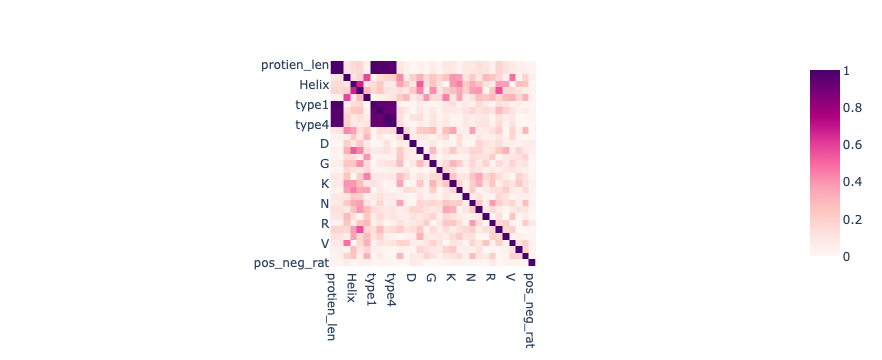

In [17]:
px.imshow(X.corr().apply(abs), color_continuous_scale="RdPu").show()

In [21]:
X_smt, y_smt = SMOTETomek(random_state=42).fit_resample(X, y)

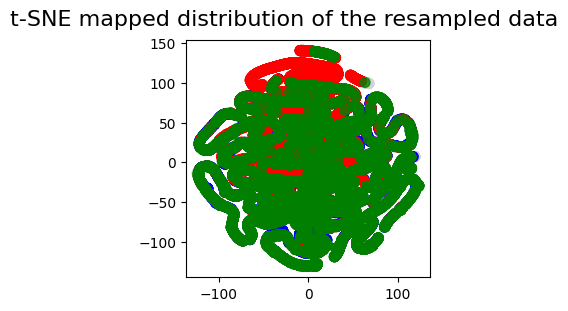

In [25]:
y_colored2 = y_smt.apply(temp)
plot_2d(t_sne.fit_transform(X_smt), y_colored2, "t-SNE mapped distribution of the resampled data")

In [33]:
y_smt.value_counts()

class
RNA        7476
DRNA       7404
DNA        7360
nonDRNA    7028
Name: count, dtype: int64

In [38]:
X_tom, y_tom = TomekLinks(sampling_strategy=["nonDRNA"]).fit_resample(X, y)

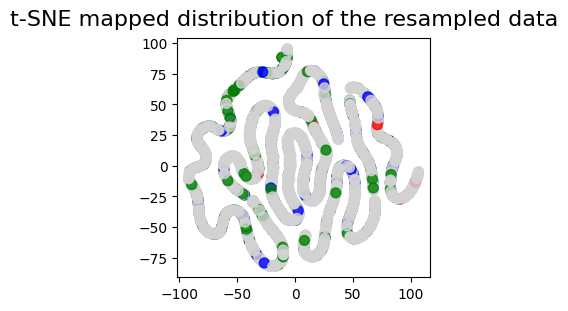

In [39]:
y_col_tom = y_tom.apply(temp)
plot_2d(t_sne.fit_transform(X_tom), y_col_tom, "t-SNE mapped distribution of the resampled data")

In [40]:
y_tom.value_counts()

class
nonDRNA    7517
RNA         523
DNA         391
DRNA         22
Name: count, dtype: int64

In [43]:
y.value_counts()

class
nonDRNA    7859
RNA         523
DNA         391
DRNA         22
Name: count, dtype: int64

In [76]:
def prec_nonDRNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["nonDRNA"], average=None, zero_division=0)

def prec_DNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["DNA"], average=None, zero_division=0)

def prec_RNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["RNA"], average=None, zero_division=0)

def prec_DRNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["DRNA"], average=None, zero_division=0)

def rec_nonDRNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["nonDRNA"], average=None, zero_division=0)

def rec_DNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["DNA"], average=None, zero_division=0)

def rec_RNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["RNA"], average=None, zero_division=0)

def rec_DRNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["DRNA"], average=None, zero_division=0)


In [137]:
knn = KNeighborsClassifier()
params = {"classifier__n_neighbors": [5,6,7,8,9,10],
         'preprocessor': [StandardScaler(), MinMaxScaler(), QuantileTransformer()]}

scoring = {
        'precision_nonDRNA': make_scorer(prec_nonDRNA),
        'precision_DNA':     make_scorer(prec_DNA),
        'precision_RNA':     make_scorer(prec_RNA),
        'precision_DRNA':    make_scorer(prec_DRNA),
        'recall_nonDRNA':    make_scorer(rec_nonDRNA),
        'recall_DNA':        make_scorer(rec_DNA),
        'recall_RNA':        make_scorer(rec_RNA),
        'recall_DRNA':       make_scorer(rec_DRNA)
    }

pipe = Pipeline([
    ('sampler', TomekLinks()),
    ('preprocessor', StandardScaler()),
    ('classifier', KNeighborsClassifier(weights='distance'))
])


gs = GridSearchCV(pipe, params, scoring=scoring,refit=False , cv=5, n_jobs=-1)

In [138]:
gs.fit(X, y)

,estimator,Pipeline(step...'distance'))])
,param_grid,"{'classifier__n_neighbors': [5, 6, ...], 'preprocessor': [StandardScaler(), MinMaxScaler(), ...]}"
,scoring,"{'precision_DNA': make_scorer(p...hod='predict'), 'precision_DRNA': make_scorer(p...hod='predict'), 'precision_RNA': make_scorer(p...hod='predict'), 'precision_nonDRNA': make_scorer(p...hod='predict'), ...}"
,n_jobs,-1
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [139]:
results = pd.DataFrame(gs.cv_results_)

In [140]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__n_neighbors', 'param_preprocessor', 'params',
       'split0_test_precision_nonDRNA', 'split1_test_precision_nonDRNA',
       'split2_test_precision_nonDRNA', 'split3_test_precision_nonDRNA',
       'split4_test_precision_nonDRNA', 'mean_test_precision_nonDRNA',
       'std_test_precision_nonDRNA', 'rank_test_precision_nonDRNA',
       'split0_test_precision_DNA', 'split1_test_precision_DNA',
       'split2_test_precision_DNA', 'split3_test_precision_DNA',
       'split4_test_precision_DNA', 'mean_test_precision_DNA',
       'std_test_precision_DNA', 'rank_test_precision_DNA',
       'split0_test_precision_RNA', 'split1_test_precision_RNA',
       'split2_test_precision_RNA', 'split3_test_precision_RNA',
       'split4_test_precision_RNA', 'mean_test_precision_RNA',
       'std_test_precision_RNA', 'rank_test_precision_RNA',
       'split0_test_precision_DRNA', 'split1_test_precision_

In [142]:
results[['param_classifier__n_neighbors','param_preprocessor', 
        'mean_test_precision_nonDRNA',
        'mean_test_precision_DNA',
        'mean_test_precision_RNA',
        'mean_test_precision_DRNA',
        'mean_test_recall_nonDRNA',
        'mean_test_recall_DNA',
        'mean_test_recall_RNA',
        'mean_test_recall_DRNA']][results['mean_test_precision_DRNA'] > 0.3]

,param_classifier__n_neighbors,param_preprocessor,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
0,5,StandardScaler(),0.915446,0.545299,0.793942,0.4,0.993256,0.102304,0.286758,0.09
1,5,MinMaxScaler(),0.913972,0.499499,0.792540,0.4,0.993510,0.087017,0.273443,0.09
3,6,StandardScaler(),0.914885,0.561727,0.826936,0.4,0.994274,0.094645,0.292601,0.09
5,6,QuantileTransformer(),0.918939,0.560000,0.796371,0.4,0.993765,0.086920,0.346007,0.09
6,7,StandardScaler(),0.913128,0.580769,0.799373,0.4,0.995037,0.076728,0.267747,0.09
7,7,MinMaxScaler(),0.910267,0.558333,0.788552,0.4,0.995165,0.064005,0.227582,0.09
8,7,QuantileTransformer(),0.917611,0.533042,0.804055,0.4,0.994783,0.079228,0.330769,0.09
9,8,StandardScaler(),0.913042,0.591270,0.810410,0.4,0.995292,0.079260,0.267747,0.09
10,8,MinMaxScaler(),0.910510,0.553247,0.778690,0.4,0.995546,0.056313,0.235201,0.09
11,8,QuantileTransformer(),0.916643,0.523959,0.785527,0.4,0.994783,0.071503,0.315440,0.09


distance appears to be better for weights than uniform

with TOMEK links, 12 or more NN causes precision and recall for DRNA to be 0

some kind of scailing is needed

I will be prioritizing precission for this model due to it already having good precission compared to recall

# The Model to use (11-20-25)
final prams (for now):
```
pipe = Pipeline([
    ('sampler', TomekLinks()),
    ('preprocessor', StandardScaler()),
    ('classifier', KNeighborsClassifier(weights='distance', n_neighbors=8))
])
```
test scores:

In [240]:
results[['param_classifier__n_neighbors','param_preprocessor', 
        'mean_test_precision_nonDRNA',
        'mean_test_precision_DNA',
        'mean_test_precision_RNA',
        'mean_test_precision_DRNA',
        'mean_test_recall_nonDRNA',
        'mean_test_recall_DNA',
        'mean_test_recall_RNA',
        'mean_test_recall_DRNA']].iloc[9]

param_classifier__n_neighbors                   8
param_preprocessor               StandardScaler()
mean_test_precision_nonDRNA              0.913042
mean_test_precision_DNA                   0.59127
mean_test_precision_RNA                   0.81041
mean_test_precision_DRNA                      0.4
mean_test_recall_nonDRNA                 0.995292
mean_test_recall_DNA                      0.07926
mean_test_recall_RNA                     0.267747
mean_test_recall_DRNA                        0.09
Name: 9, dtype: object

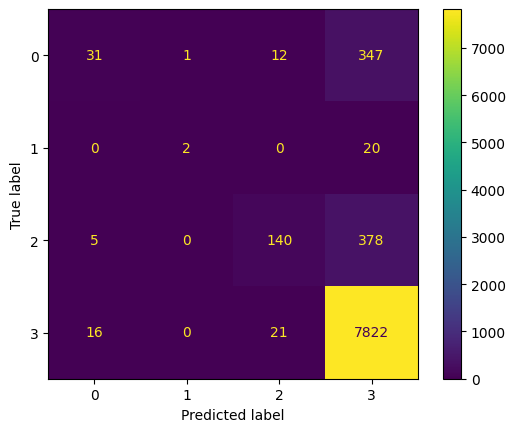

In [244]:
pipe = Pipeline([
    ('sampler', TomekLinks()),
    ('preprocessor', StandardScaler()),
    ('classifier', KNeighborsClassifier(weights='distance', n_neighbors=8))
])

y_pred = cross_val_predict(pipe, X, y, cv=5)

cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning:

The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.



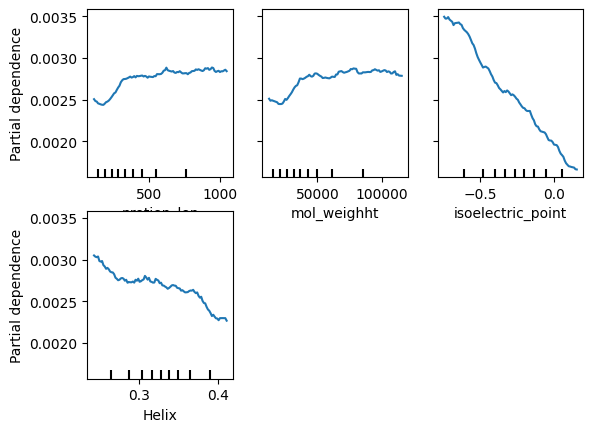

In [190]:
PartialDependenceDisplay.from_estimator(knn2, X_train, X_test.columns[:4], target='DRNA')
plt.show()

/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning:

The column 6 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.

/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning:

The column 7 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.

/Users/connorfair/CMSC_436_Projects/Gr

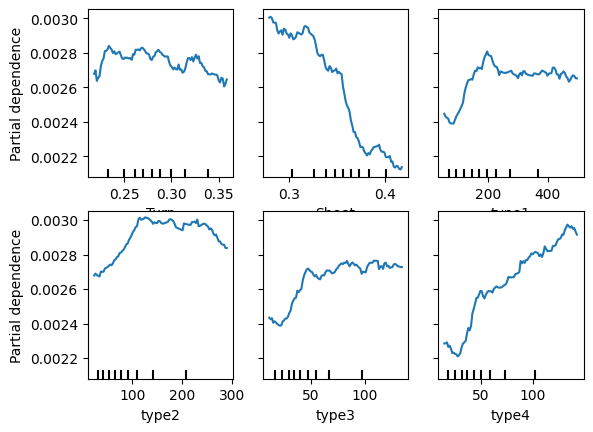

In [189]:
PartialDependenceDisplay.from_estimator(knn2, X_train, X_test.columns[4:10], target='DRNA')
plt.show()

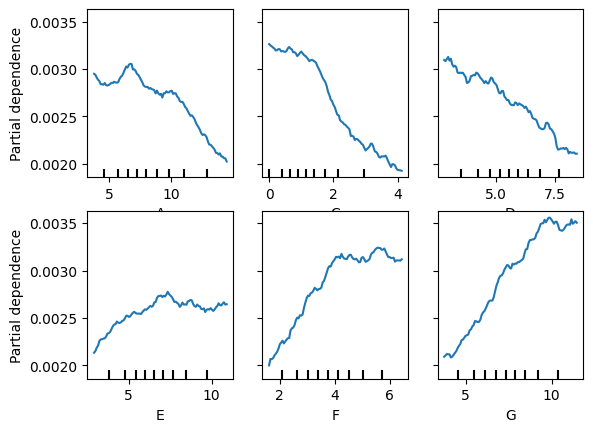

In [185]:
PartialDependenceDisplay.from_estimator(knn2, X_train, X_test.columns[10:16], target='DRNA')
plt.show()

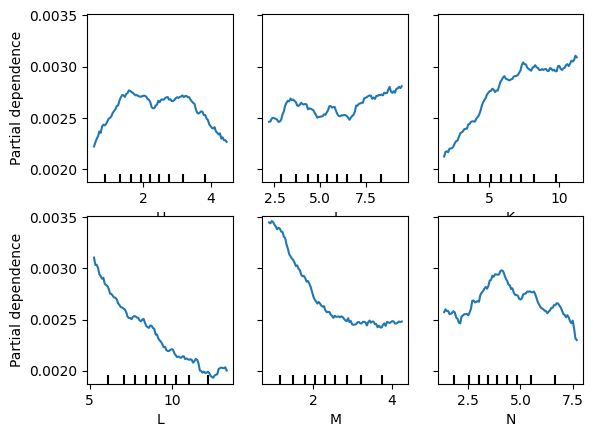

In [186]:
PartialDependenceDisplay.from_estimator(knn2, X_train, X_test.columns[16:22], target='DRNA')
plt.show()

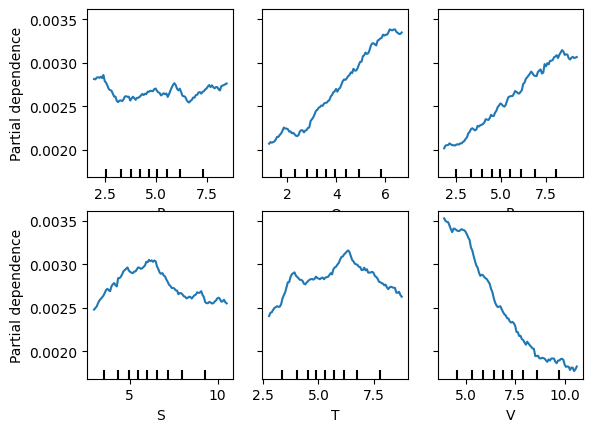

In [187]:
PartialDependenceDisplay.from_estimator(knn2, X_train, X_test.columns[22:28], target='DRNA')
plt.show()

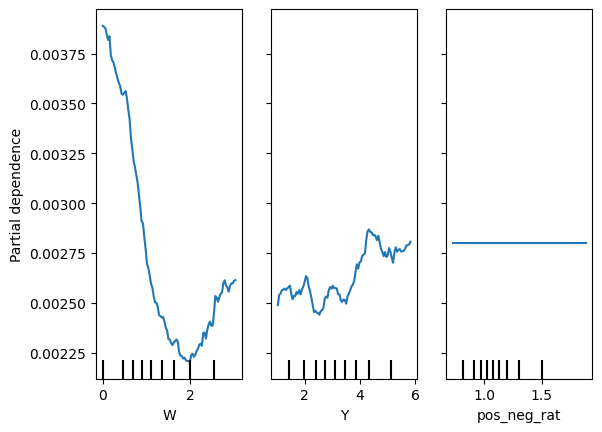

In [188]:
PartialDependenceDisplay.from_estimator(knn2, X_train, X_test.columns[28:], target='DRNA')
plt.show()

In [175]:
len(X_test.columns)

31

In [192]:
feat_imp = permutation_importance(knn2, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

[]

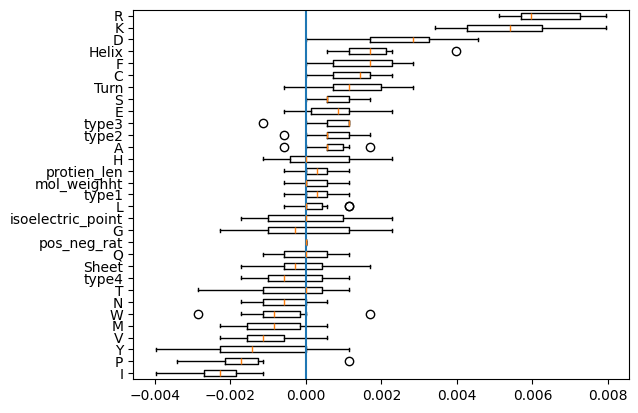

In [207]:
plt.boxplot(x=feat_imp.importances[feat_imp.importances_mean.argsort()].T, vert=False, tick_labels =  X_test.columns[feat_imp.importances_mean.argsort()])

plt.axvline(x=0)
plt.plot()

Will adding a random oversampler increase recall?

In [233]:
params = {"classifier__n_neighbors": list(range(26,71,2))}

scoring = {
        'precision_nonDRNA': make_scorer(prec_nonDRNA),
        'precision_DNA':     make_scorer(prec_DNA),
        'precision_RNA':     make_scorer(prec_RNA),
        'precision_DRNA':    make_scorer(prec_DRNA),
        'recall_nonDRNA':    make_scorer(rec_nonDRNA),
        'recall_DNA':        make_scorer(rec_DNA),
        'recall_RNA':        make_scorer(rec_RNA),
        'recall_DRNA':       make_scorer(rec_DRNA)
    }

pipe = Pipeline([
    ('sampler', TomekLinks()),
    ('sampler2', RandomOverSampler(random_state=42)),
    ('preprocessor', StandardScaler()),
    ('classifier', KNeighborsClassifier(weights='distance'))
])


gs2 = GridSearchCV(pipe, params, scoring=scoring,refit=False , cv=5, n_jobs=-1)

In [234]:
gs2.fit(X,y)

,estimator,Pipeline(step...'distance'))])
,param_grid,"{'classifier__n_neighbors': [26, 28, ...]}"
,scoring,"{'precision_DNA': make_scorer(p...hod='predict'), 'precision_DRNA': make_scorer(p...hod='predict'), 'precision_RNA': make_scorer(p...hod='predict'), 'precision_nonDRNA': make_scorer(p...hod='predict'), ...}"
,n_jobs,-1
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [235]:
results2 = pd.DataFrame(gs2.cv_results_)
results2[['param_classifier__n_neighbors', 
        'mean_test_precision_nonDRNA',
        'mean_test_precision_DNA',
        'mean_test_precision_RNA',
        'mean_test_precision_DRNA',
        'mean_test_recall_nonDRNA',
        'mean_test_recall_DNA',
        'mean_test_recall_RNA',
        'mean_test_recall_DRNA']]#[results['mean_test_precision_DRNA'] > 0.3]

,param_classifier__n_neighbors,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
0,26,0.963261,0.152002,0.257039,0.021333,0.743353,0.513989,0.600403,0.14
1,28,0.964777,0.150817,0.249334,0.019907,0.731138,0.529341,0.606136,0.14
2,30,0.965542,0.147456,0.241915,0.019018,0.716124,0.539533,0.613828,0.14
3,32,0.965812,0.144596,0.233364,0.017477,0.703527,0.544628,0.613846,0.14
4,34,0.966354,0.141456,0.228892,0.016317,0.693221,0.552321,0.610037,0.14
5,36,0.966955,0.139724,0.225339,0.015638,0.683932,0.562577,0.608132,0.14
6,38,0.966572,0.135609,0.222218,0.015406,0.675535,0.562577,0.604304,0.14
7,40,0.966817,0.132414,0.222968,0.015017,0.670318,0.565141,0.604322,0.14
8,42,0.966082,0.130446,0.223513,0.014708,0.669428,0.570237,0.590952,0.14
9,44,0.966962,0.129310,0.228184,0.013696,0.669173,0.580461,0.581355,0.14


yes, but I don't think that this is worth pursuing for this model right now. 